In [4]:
import numpy as np
import os
import sys

from simulation import heart_rate
from matplotlib import pyplot as plt
from scipy import signal as ss
from utils.wall_processing import distance_processing
import utils.signal as sp
#%matplotlib widget

plt.style.use('seaborn-whitegrid')

RMSE 0.23159518307012814


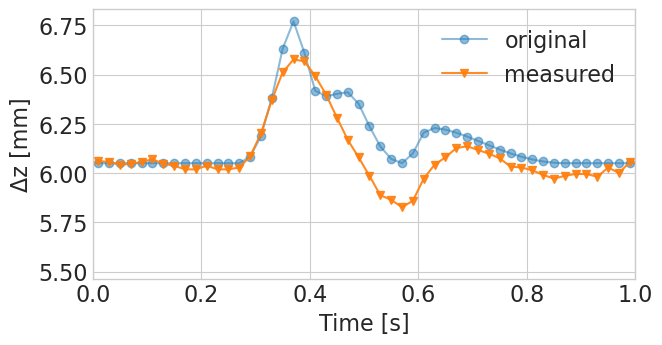

In [41]:
bpm = 60
def get_raw(file_name):
    data_file = np.load(file_name)#np.load(f"data_{bpm}bpm_1.0amp.npz")s
    #print(  data_file['acq_num_arr'])
    return data_file['data_arr'][:,:]

raw_data = get_raw(f"Arterie_wall/data_{bpm}bpm_1.0amp.npz")
    
pulse, _ = distance_processing(raw_data)
meas_period= 20_000 / 1E6
t = np.arange(0,len(pulse)*meas_period,meas_period)

hr_func = heart_rate.HeartRateWave(bpm)
plt.figure(figsize=(7,3.5))
plt.plot(t-3.75,((hr_func(t-.72+1)-.2)*.9+6.05), 'o-', label="original", alpha=0.5)
plt.plot(t-3.75,np.array(pulse[:]), 'v-', label="measured", alpha=.9)
plt.xlabel("Time [s]")
plt.ylabel("Δz [mm]")
#np.argwhere(dist == np.amax(dist))
#74*meas_period # periode -> 1.48s vs 1.5s (40bpm)
plt.legend()
plt.xlim((0,1))
#meas_period
#plt.tight_layout()
plt.savefig('pulse_no_filter.svg')  

print("RMSE", np.sqrt(((((hr_func(t-.72+1)-.2)*.9+6.05)-np.array(pulse[:]))**2).mean())/.55)

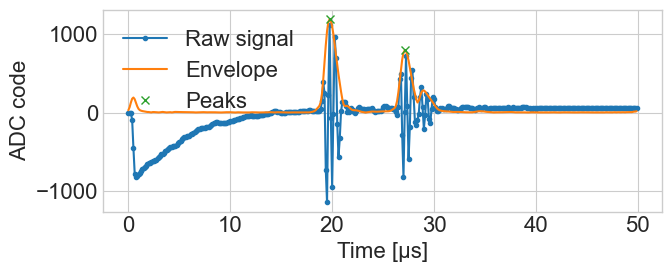

In [17]:
plt.figure(figsize=(7,3))
t= np.arange(0,400)/8
plt.plot(t,raw_data[:,0],'.-',label="Raw signal")
data_smpl = raw_data[:,0]
data_filt = sp.butter_bp(data_smpl,(1e6,2.8e6),8e6)
env = np.abs(ss.hilbert(data_filt))
plt.plot(t,np.abs(ss.hilbert(data_filt)),label="Envelope")
plt.xlabel("Time [μs]")
plt.ylabel("ADC code")
peaks = np.array([158,217])
plt.plot(peaks/8,env[peaks],'x',label="Peaks")
plt.legend()
0
plt.tight_layout()
plt.savefig("raw_data.pdf")

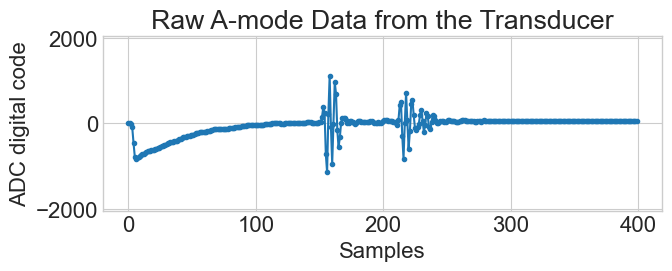

In [18]:
plt.close("all")
plt.figure(figsize=(7,3))
plt.plot(np.array(raw_data[:,0]),'.-')
plt.title("Raw A-mode Data from the Transducer")
plt.ylim(-2048,2048)
plt.ylabel("ADC digital code")
plt.xlabel("Samples")
plt.grid(True,which="both")
plt.tight_layout()
plt.savefig('raw_wuplpus2.pdf')  

### Step Function to estimate the Transfert function

In [19]:
def get_raw(file_name):
    data_file = np.load(file_name)#np.load(f"data_{bpm}bpm_1.0amp.npz")s
    return data_file['data_arr'][:,:]

N = 8
raw_data = [get_raw(f"Arterie_wall/step_1.0_{n}.npz") for n in range(N)]
    
distance = [distance_processing(data)[0] for data in raw_data]


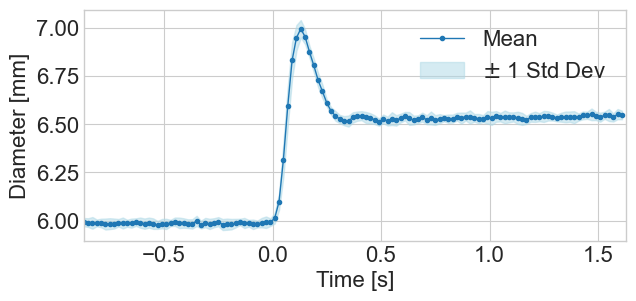

In [20]:
meas_period= 20_000 / 1E6

plt.figure(figsize=(7,3))
t = np.arange(0,len(distance[0])*meas_period,meas_period)

dist = []
for n,d in enumerate(distance):
    i = np.argmax(d)
    if n!=6:
        dist += [d[i-50:i+75]]
dist = np.array(dist)
o = .87
#plt.plot(t[:125]-o,dist.T,'.-', color='gray',alpha=.5)

mean_y = np.mean(dist,axis=0)
std_y = np.std(dist,axis=0)
plt.plot(t[:125]-o,mean_y,'.-',linewidth=1,label='Mean')

plt.fill_between(t[:125]-o, mean_y - std_y, mean_y + std_y, color='lightblue', alpha=0.5, label=r'$\pm$ 1 Std Dev')

plt.xlabel("Time [s]")
plt.ylabel("Diameter [mm]")
plt.legend()
plt.xlim((0-o,2.5-o))
#plt.ylim((5.9,7.1))
meas_period
plt.savefig('step_response.pdf')  

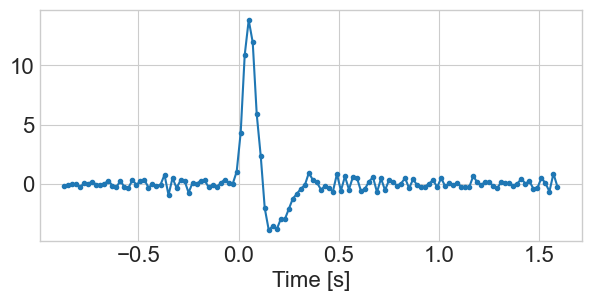

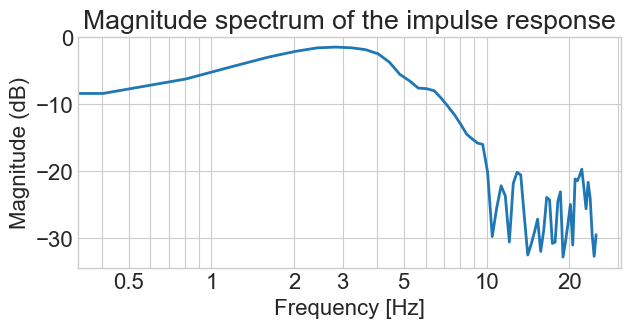

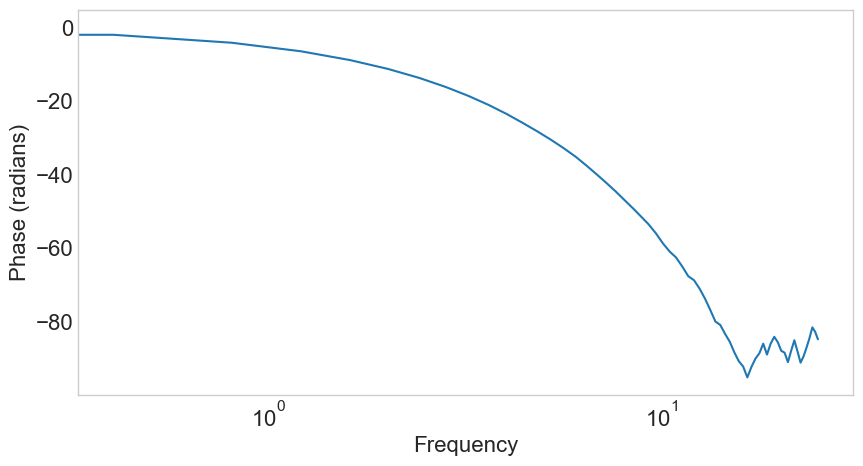

In [21]:
step_response = np.mean(dist,axis=0)
impulse_response = (step_response[1:]-step_response[:-1])/meas_period
plt.figure(figsize=(7,3))
plt.plot(t[:124]-o,impulse_response,'.-')
plt.xlabel("Time [s]")

plt.figure(figsize=(7,3))
plt.title("Magnitude spectrum of the impulse response")
plt.magnitude_spectrum(impulse_response,1/meas_period,scale="dB",lw=2)
plt.xlabel("Frequency [Hz]")
plt.xscale("log")
tck = [.5,1,2,3,5,10,20]
plt.xticks(tck,[str(i)+"" for i in tck])
#plt.xlim((1,10))
plt.grid(True,which='both')
plt.savefig('transferfunction_empirical.pdf')  
#plt.ylim((-10,5))
plt.figure(figsize=(10,5))
plt.phase_spectrum(impulse_response,1/meas_period)
plt.grid()
plt.xscale("log")




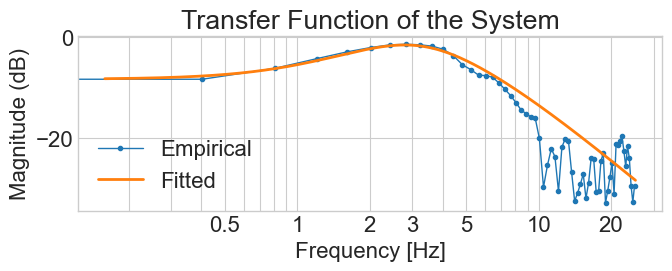

In [22]:
K=1/np.sqrt(10)*1.2
wp=3.2*2*np.pi
wz=1*2*np.pi
damp=0.7
H=lambda w: K*wp**2*(1j*w/wz+1)/((1j*w)**2+2*damp*wp*1j*w+wp**2)/((1j*w/wp/2+1))
freq = np.logspace(-0,2.2,1000)
plt.figure(figsize=(7,3))
plt.title("Transfer Function of the System")
plt.magnitude_spectrum(impulse_response,1/meas_period,scale="dB",lw=1,marker='.',label='Empirical')
plt.xlabel("Frequency [Hz]")
plt.xscale("log")
tck = [.5,1,2,3,5,10,20]
plt.xticks(tck,[str(i)+"" for i in tck])
#plt.xlim((1,10))
plt.grid(True,which='both')

plt.plot(freq/2/np.pi,20*np.log(np.abs(H(freq)))/np.log(10),linewidth=2,label="Fitted")
plt.legend()
plt.tight_layout()
plt.savefig("TF_fit.png")

#### Convolving the input with the impulse response to see it it matches

Text(0, 0.5, 'Diameter [mm]')

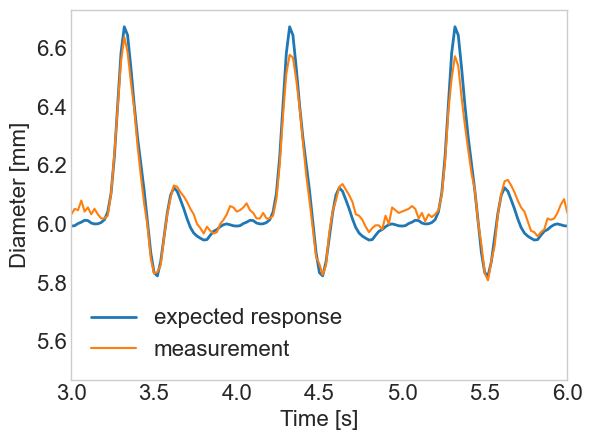

In [23]:
original_pulse = (hr_func(t)-.2)
expected = ss.convolve(original_pulse,impulse_response)
plt.plot(t,expected[:500]/45+6, label="expected response",linewidth=2)
plt.plot(t+.2,pulse, label="measurement")
#plt.plot(impulse_response)
plt.xlim((3,6))
plt.legend()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Diameter [mm]")

<function matplotlib.pyplot.show(close=None, block=None)>

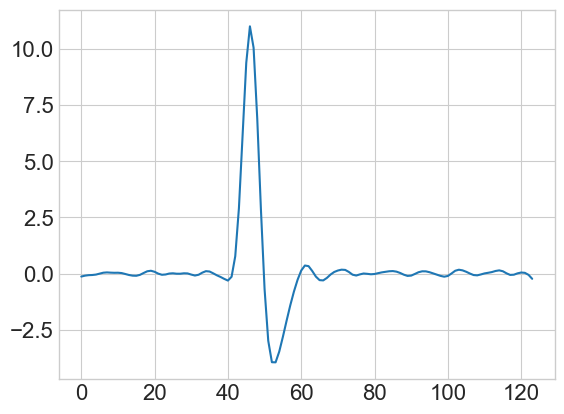

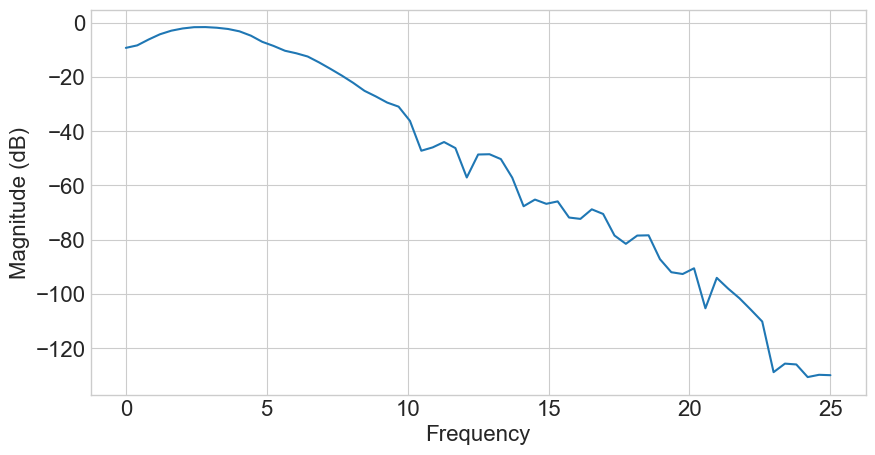

In [24]:
fs =1/meas_period
fc = 7  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = ss.butter(2, w, 'low')
filtered_impulse = ss.filtfilt(b, a, impulse_response)
plt.plot(filtered_impulse)
plt.figure(figsize=(10,5))
plt.magnitude_spectrum(filtered_impulse,1/meas_period, scale="dB")
plt.show

-0.8370535714285587

(0.2, 3.0)

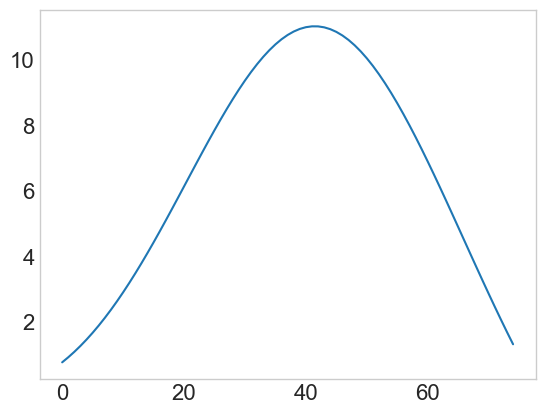

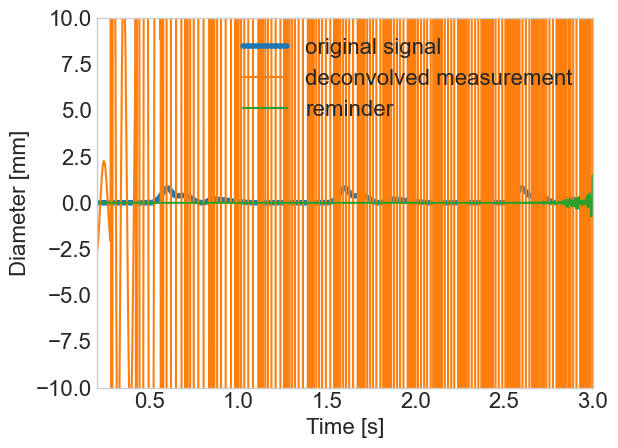

In [25]:
filtered_impulse2=ss.resample(filtered_impulse, filtered_impulse.shape[-1] * 10,axis=-1)

plt.plot(filtered_impulse2[420:495])
plt.grid()

display(impulse_response[58])
t = np.arange(0,10,meas_period/10)
original_pulse_os = (hr_func(t)-.2)
plt.figure()
rectified,reminder = ss.deconvolve(original_pulse_os+10,filtered_impulse2[420:490])
plt.plot(t+.2,original_pulse_os, label="original signal",linewidth=4)
plt.plot(t[:len(rectified)],rectified, label="deconvolved measurement")
plt.plot(t, reminder,label="reminder")
#plt.plot(impulse_response)
#plt.xlim((3,6))
plt.legend()
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Diameter [mm]")
plt.ylim((-10,10))
plt.xlim((.2,3))

### Deconvolving the input signal by estimating the transfer function

ValueError: x and y must have same first dimension, but have shapes (5000,) and (500,)

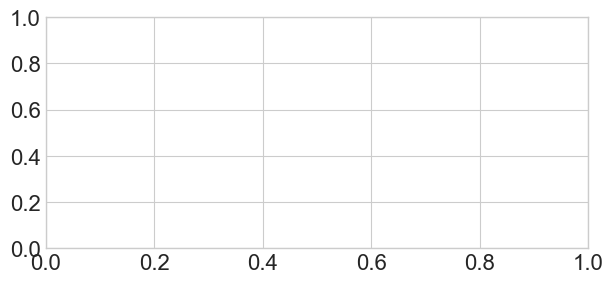

In [26]:
a = [0.3984, -0.447, 0.08432]
b = [1, -1.523, 0.6361]
signal_to_deconv = original_pulse# np.array(pulse) -6origi
y = ss.lfilter(b, a, signal_to_deconv)
plt.figure(figsize=(7,3))
plt.plot(t,(signal_to_deconv+.2)/0.003051184667,'o-',alpha=.5,label="original")
plt.plot(t,(y[:]/1.6+.2)/0.003051184667, 'v-',alpha=.9,label="de-convolved")
reconv = ss.convolve(y,filtered_impulse)/2
#plt.plot(reconv[46:]*1.7,label="re-convolved")
plt.xlim((-0.05,100*t[1]))
plt.xlabel("Time [s]")
plt.ylabel("Motor Speed [rpm]")
plt.legend()
plt.ylim(0,360)
t[15-15:66-15]*10
plt.savefig('deconv_pulse.pdf')  

In [27]:
plt.figure(figsize=(7,3))
from scipy.interpolate import PchipInterpolator
smooth = PchipInterpolator(t,(y[:]/1.6+.2)/0.003051184667)
t2= np.linspace(0,3,1000)
plt.plot(t2,smooth(t2),'k')
#plt.grid(False)
plt.xlim((-0.05,150*t[1]))
plt.xlabel("Time [s]")
plt.ylabel("Motor Speed [rpm]")
plt.ylim(-0.05,400)
plt.savefig('pulse_decovolved.svg')  

ValueError: The length of `y` along `axis`=0 doesn't match the length of `x`

<Figure size 700x300 with 0 Axes>

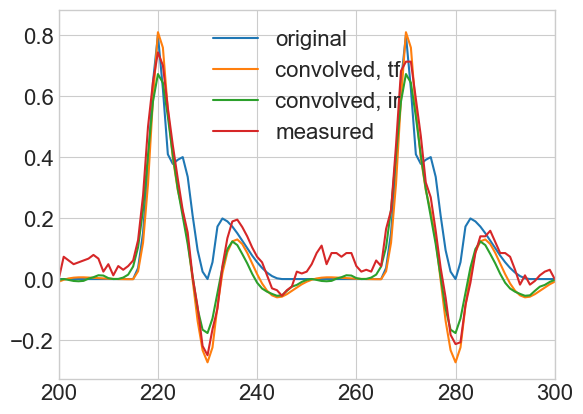

In [28]:
a = [0.3984, -0.447, 0.08432]
b = [1, -1.523, 0.6361]
signal_to_conv = original_pulse# np.array(pulse) -6origi
y = ss.lfilter(a, b, signal_to_conv)

plt.plot(signal_to_conv,label="original")
plt.plot(y*1.8, label="convolved, tf")
plt.plot(expected[46:]/45,label="convolved, ir")
plt.plot((np.array(pulse[36:])-6)*1.3,label="measured")
plt.xlim((200,300))
plt.legend()

### after measuring the deconvolved pulse

500
RMSE 0.08473494121681892


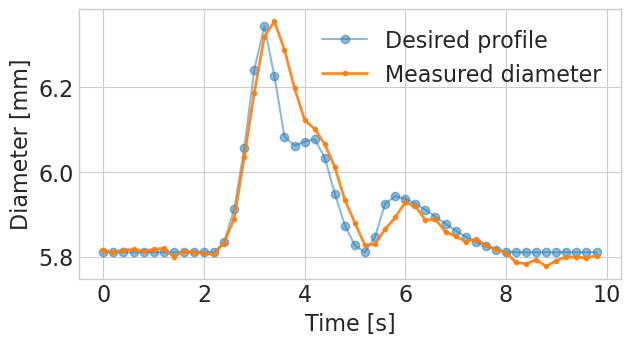

In [42]:
deconv = get_raw(f"Arterie_wall/deconv_out_2.npz")
deconv_pulse = np.array(distance_processing(deconv)[0])
print(len(deconv_pulse))
#plt.plot(deconv_pulse[122:]-5.8)
#plt.plot(reconv[50:])
plt.figure(figsize=(7,3.5))
plt.plot(t[:50]*10,original_pulse[4:54]/1.5+5.81,'o-',alpha=.5,label="Desired profile")
#plt.xlim((40,150))

ave_deconv_pulse = np.zeros_like(deconv_pulse[:50])
for i in range(10):
    ave_deconv_pulse += deconv_pulse[i*50:(i+1)*50]/10
ave_deconv_pulse= np.concatenate([ave_deconv_pulse[21:],ave_deconv_pulse[:21]])
plt.plot(t[:50]*10,ave_deconv_pulse,'.-',alpha=.9,label="Measured diameter",linewidth=2)
#plt.xlim((0,150*t[1]))
plt.xlabel("Time [s]")
plt.ylabel("Diameter [mm]")
plt.legend()
plt.savefig('recovered_pulse.svg') 
print("RMSE", np.sqrt(((original_pulse[4:54]/1.5+5.81-ave_deconv_pulse)**2).mean())/.55)

BF Final dB range (-5.0,0.0)


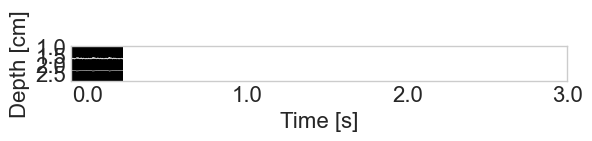

In [30]:
envelopes = distance_processing(deconv)[1]

# from pybf (sergei's github)
def log_compress(image, db_range, reference_max=None):

    db_range = abs(db_range)

    image_temp = image.copy()

    # If reference maximum value is specified
    # truncate the data
    if reference_max is not None:
        image_temp[image_temp > reference_max] = reference_max

    # Calc max value
    if (reference_max is not None) and (reference_max > image_temp.max()):
        max_value = reference_max
    else:
        max_value = image_temp.max()

    # Log scale transform
    image_log = 20 * np.log10(image_temp/max_value)

    # Truncate
    image_log[image_log < (-db_range)] = -db_range

    print("BF Final dB range ({:2.1f},{:2.1f})".format(image_log.min(),
                                                       image_log.max()))
    return image_log

distance = np.array([1,1.5,2,2.5])
mm_per_sample = 1_500/2 /8e8 *1_000/10
sample = (distance-1)/mm_per_sample/10*1.8
time =  np.array([0,1.,2,3])
sample_time = (time+.1)/t[1]

plt.imshow(log_compress(envelopes.T[1900:5500,70:230],5),aspect=.03,cmap='gist_gray',interpolation='none')
#plt.colorbar()
plt.yticks(sample,distance)
plt.xticks(sample_time,time)
plt.grid(False)
plt.ylabel("Depth [cm]")
plt.xlabel("Time [s]")
plt.savefig("m-mode.svg")

In [31]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [5]:
from scipy.interpolate import PchipInterpolator
pulse_sonix_raw = np.array([[0.19323671497584544, 0.29681978798586584],
[0.23188405797101447, 0.2826855123674914],
[0.28985507246376807, 0.26148409893992963],
[0.33333333333333337, 0.25795053003533575],
[0.39613526570048313, 0.25795053003533575],
[0.46859903381642515, 0.2650176678445231],
[0.5217391304347827, 0.2720848056537104],
[0.57487922705314, 0.2826855123674914],
[0.6183574879227052, 0.3674911660777387],
[0.6328502415458936, 0.5123674911660779],
[0.6618357487922706, 0.6466431095406362],
[0.6763285024154588, 0.756183745583039],
[0.7004830917874396, 0.8197879858657245],
[0.7101449275362317, 0.8621908127208482],
[0.7294685990338163, 0.8833922261484101],
[0.7536231884057971, 0.9010600706713783],
[0.7826086956521738, 0.8869257950530037],
[0.8019323671497585, 0.8480565371024736],
[0.8212560386473429, 0.7314487632508836],
[0.855072463768116, 0.5936395759717316],
[0.8743961352657006, 0.5265017667844525],
[0.9178743961352658, 0.4487632508833924],
[0.9565217391304348, 0.4381625441696114],
[1.0096618357487923, 0.45583038869257964],
[1.0434782608695652, 0.46289752650176696],
[1.0966183574879227, 0.4381625441696114],
[1.1304347826086956, 0.36042402826855136],
[1.1690821256038648, 0.28621908127208484],
[1.2270531400966185, 0.25795053003533575],
[1.2946859903381644, 0.25795053003533575],
[1.3623188405797102, 0.25795053003533575],
[1.4154589371980677, 0.27561837455830407],
[1.463768115942029, 0.28621908127208484],
[1.5217391304347825, 0.28621908127208484],
[1.5845410628019323, 0.30388692579505316],
[1.5990338164251208, 0.38162544169611323],
[1.6280193236714975, 0.4982332155477033],
[1.6521739130434783, 0.6219081272084808],
[1.6666666666666665, 0.7526501766784455],
[1.6763285024154588, 0.816254416961131],
[1.710144927536232, 0.893992932862191],
[1.7391304347826086, 0.932862190812721],
[1.777777777777778, 0.8798586572438165],
[1.8115942028985506, 0.7844522968197881],
[1.8405797101449277, 0.6431095406360426],
[1.8792270531400967, 0.4770318021201415],
[1.9275362318840579, 0.413427561837456],
[1.9758454106280194, 0.4487632508833924],
[2.038647342995169, 0.4416961130742051],
[2.077294685990338, 0.40989399293286244],
[2.1062801932367146, 0.33215547703180226],
[2.154589371980676, 0.2826855123674914],
[2.2173913043478257, 0.2544169611307423],
[2.2801932367149753, 0.24734982332155497],
[2.3526570048309177, 0.25088339222614864],
[2.444444444444444, 0.25795053003533575],
[2.5555555555555554, 0.26855123674911674],
[2.589371980676328, 0.3356890459363959],
[2.623188405797101, 0.47349823321554785],
[2.6280193236714973, 0.579505300353357],
[2.652173913043478, 0.6855123674911662],
[2.6666666666666665, 0.7844522968197881],
[2.690821256038647, 0.855123674911661],
[2.7198067632850242, 0.893992932862191],
[2.739130434782608, 0.932862190812721],
[2.7632850241545888, 0.893992932862191],
[2.7971014492753623, 0.8480565371024736],
[2.8115942028985503, 0.7915194346289754],
[2.826086956521739, 0.7137809187279153],
[2.835748792270531, 0.6289752650176681],
[2.8550724637681157, 0.5547703180212016],
[2.8937198067632846, 0.4699646643109542],
[2.932367149758454, 0.4204946996466433],
[2.9855072463768115, 0.44522968197879875]])
#display(np.diff(pulse_sonix_raw.T))
x,y = (pulse_sonix_raw.T[0],pulse_sonix_raw.T[1])
pulse_sonix = PchipInterpolator(x,y)



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.0027827827827827945
RMSE 0.1710564485709059
mean sonix: 0.4435852247646536
mean origin: 0.3251029672864366


0.2170570570570569

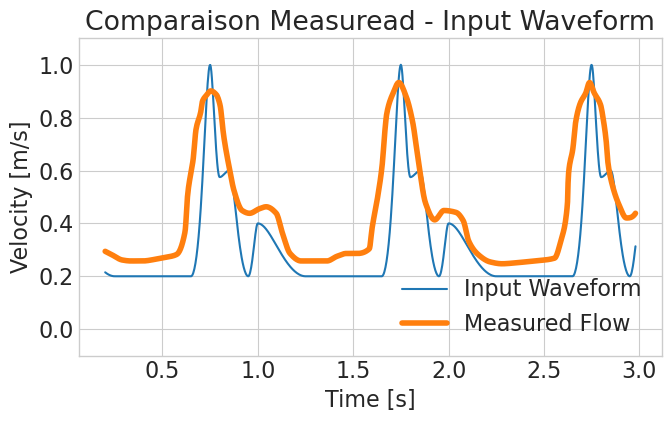

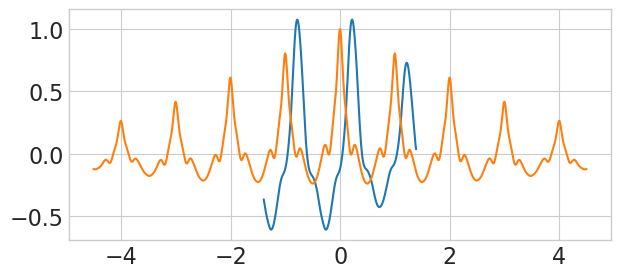

In [43]:
time_array = np.linspace(0.2,2.98,1000)
puls= pulse_sonix(time_array)
hr=hr_func(time_array+.65)
plt.figure(figsize=(7,4.5))
plt.plot(time_array,(hr),label="Input Waveform")#-hr.mean())/hr.std())
plt.plot(time_array,(puls),label="Measured Flow",linewidth=4)#-puls.mean())/puls.std())
plt.ylim(-0.1,1.1)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.legend(loc='lower right')
plt.title("Comparaison Measuread - Input Waveform")
plt.tight_layout()
#plt.savefig("comp_flow.png")
import sklearn
import scipy
dt= time_array[1]-time_array[0]
print(dt)
time_hr = np.arange(-3,6,dt)

print("RMSE", np.sqrt(((pulse_sonix(time_array)-hr_func(time_array+.65))**2).mean()))
print("mean sonix:", pulse_sonix(time_array).mean())
print("mean origin:", hr_func(time_array+.65).mean())
def cross_correlation(x,y,mode='same'):
    x_mean = x.mean()
    y_mean = y.mean()
    x_std = x.std()
    y_std = y.std()
    N = min(len(x),len(y))
    correl = scipy.signal.correlate(x-x_mean,y-y_mean,mode=mode)/N
    return correl/x_std/y_std
plt.figure(figsize=(7,3))
#scipy.signal.correlate(pulse_sonix(time_array),hr_func(np.arange(-3,6,dt)))
cc = cross_correlation(pulse_sonix(time_array),hr_func(time_hr))
plt.plot(time_array-time_array[len(time_array)//2+1],cc)
plt.plot(time_hr-time_hr[len(time_hr)//2+1],cross_correlation(hr_func(time_hr),hr_func(time_hr)))
#plt.xlim(-1,1)
(time_array-time_array[len(time_array)//2+1])[cc.argmax()]

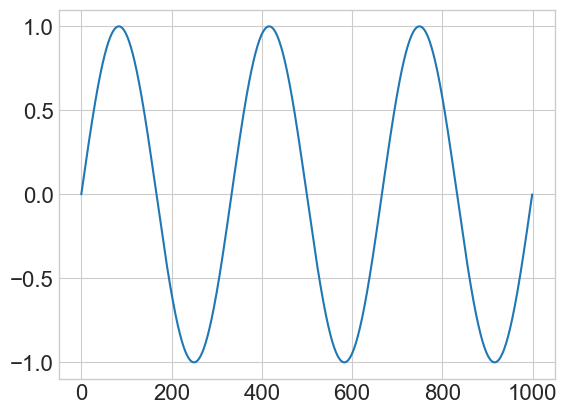

In [7]:
plt.plot(np.sin(2*np.pi*np.linspace(0,3,1000)))
plt.savefig("sin.svg")

In [ ]:
pulse, _ = distance_processing(raw_data)